<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1 Mount to Google Drive

The complete computation is done on Google Colab. The following code mounts the Google Drive to the Colab environment.

In [45]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2 Import relevant libraries, define relevant paths, and model hyperparameters

In [46]:
# for opening installed packages (installed in virtual environment of Google Colab)
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')
# for importing modules defined in other jupyter notebooks
import import_ipynb

In [47]:
# import relevant libraries

import os # for file handling
import glob # for file handling
import random # generate random numbers and seed setting
from tqdm import tqdm # for counter

import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for plotting

from PIL import Image # read and save images

import torch # for PyTorch framework
from torch.utils.data import Dataset, DataLoader # for creating custom dataset and DataLoader
import torchvision.transforms.functional as TF # for tensor transformations
import albumentations as A # for data augmentation
from torch.optim import Adam # for Adam optimizer
from torch import nn # for defining layers of unet model and resizing
import monai # for medical image segmentation loss function
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/03_sam'
from sam_dataset import SAMDataset # custom dataset class
from sam_prompt_functions import generate_input_points # for SAM model
from transformers import SamModel, SamProcessor, SamConfig # for SAM model

from sklearn.metrics import accuracy_score, recall_score, precision_score # for evaluation
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation'
from evaluation_utils import dice_score, iou_score, calculate_metrics # for evaluation
from statistics import mean # calculate mean of metrics

/content/drive/MyDrive/cbs/master_thesis/master-thesis/03_sam
/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation


In [48]:
# define dataset path
dataset_path = '/content/drive/MyDrive/cbs/master_thesis/dataset_rgb'

# define model path
model_path = '/content/drive/MyDrive/cbs/master_thesis/models'

In [49]:
# define hyperparameters to tune
batch_size = 2
number_epochs = 15
learning_rate = 0.0001

# define model name
model_name = 'medsam_model_3'

### 3 Load images and masks and create DataLoader instance

The images and masks are coming in size of 1024x1024 and are opened using the library PIL. Images and masks are loaded for training and validation.

In [50]:
def open_images_and_masks(image_files_name:list[str], mask_files_name:list[str]):
    '''
    Opens images and masks from the given paths.

    Args:
        image_files_name (list[str]): Paths to the images.
        mask_files_name (list[str]): Paths to the masks.

    Returns:
        images (list): List of images.
        masks (list): List of masks.
    '''

    # create empty lists to store patches
    images = []
    masks = []

    # for tqdm progress bar
    total_items = len(image_files_name)

    for image_path, mask_path in tqdm(zip(image_files_name, mask_files_name), total=total_items):
        # load images and masks
        image = Image.open(image_path).convert('RGB')  # RGB required by SAM
        mask = Image.open(mask_path).convert('1')  # binary

        # append images and mask to list
        images.append(image)
        masks.append(mask)

    return images, masks

#### 3.1 Load training images and masks

In [51]:
# training
# get file names of images
images_files_train = glob.glob(os.path.join(dataset_path, 'training', 'images', '*.jpg'))
images_files_train.sort()

# get file names of masks
masks_files_train = glob.glob(os.path.join(dataset_path, 'training', 'masks', '*.jpg'))
masks_files_train.sort()

# open images and masks
images_train, masks_train = open_images_and_masks(images_files_train, masks_files_train)

100%|██████████| 625/625 [00:19<00:00, 31.49it/s]


#### 3.2 Load validation images and masks

In [52]:
# validation
# get file names of images
images_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'images', '*.jpg'))
images_files_val.sort()

# get file names of masks
masks_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'masks', '*.jpg'))
masks_files_val.sort()

# open images and masks
images_val, masks_val = open_images_and_masks(images_files_val, masks_files_val)

100%|██████████| 78/78 [00:01<00:00, 44.86it/s]


#### 3.3 Create DataLoader instance

This part defines how images and masks are loaded during training and which real-time data augmentation techniques are used. The custom dataset class SAMDataset is defined in the sam_dataset.ipynb file.

In [53]:
# define which transformation is applied to the training images and masks
def custom_transformation(image, mask):
    '''
    Apply custom transformations to the image and mask.
    '''

    transform = A.Compose([
        # horizontal flipping
        A.HorizontalFlip(p=0.5),

        # vertical flipping
        A.VerticalFlip(p=0.5)
    ])

    # apply transformations to both image and mask
    augmented = transform(image=image, mask=mask)

    # return augmented image and mask
    return augmented['image'], augmented['mask']

In [54]:
# initialize the processor of SAM model
processor = SamProcessor.from_pretrained('wanglab/medsam-vit-base')

In [55]:
# create training DataLoader instance
train_dataset = SAMDataset(images=images_train, masks=masks_train, processor=processor, transforms=custom_transformation)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, worker_init_fn=np.random.seed(42))

# create validation DataLoader instance
val_dataset = SAMDataset(images=images_val, masks=masks_val, processor=processor, transforms=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [56]:
# check dimensions of dataset
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 1750, 2])
ground_truth_mask torch.Size([1, 1024, 1024])


In [57]:
# check dimensions of DataLoader
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 1, 1750, 2])
ground_truth_mask torch.Size([2, 1, 1024, 1024])


### 4 Modelling and fine-tuning

#### 4.1 Load SAM model

In [58]:
# load SAM model
model = SamModel.from_pretrained('wanglab/medsam-vit-base')

# ensure only weights for mask decoder are trained
for name, param in model.named_parameters():
    if name.startswith('vision_encoder') or name.startswith('prompt_encoder'):
        param.requires_grad_(False)

#### 4.2 Define training parameters

In [59]:
# set optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=learning_rate, weight_decay=0.01)
# set loss function
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, reduction='mean')

In [60]:
# define training loop
num_epochs = number_epochs

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create artificial best validation loss for the start
best_val_loss = 100.0
best_val_epoch = 0

# define patience for early stopping
patience = 5
patience_counter = 0

#### 4.3 Train SAM model

In [61]:
# set seed for reproducibility
torch.manual_seed(42) # for PyTorch
torch.backends.cudnn.deterministic = True # for PyTorch
torch.backends.cudnn.benchmark = False # for PyTorch
torch.cuda.manual_seed_all(42) # for GPU
np.random.seed(42) # for numpy
random.seed(42) # for any other operation

# fine-tune SAM model
model.train()
for epoch in range(num_epochs):

    # train stage
    # list to record training losses
    train_losses = []
    for train_batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=train_batch['pixel_values'].to(device),
                      input_points=train_batch['input_points'].to(device),
                      multimask_output=False)
        # compute training loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        predicted_masks = nn.functional.interpolate(predicted_masks,
                                                    size=(1024,1024),
                                                    mode='bilinear',
                                                    align_corners=False)
        ground_truth_masks = train_batch['ground_truth_mask'].float().to(device)
        # calculate loss
        loss = seg_loss(predicted_masks, ground_truth_masks)

        # backward pass
        # compute gradients of parameters with regards to the loss
        optimizer.zero_grad()
        loss.backward()
        # optimize the weights
        optimizer.step()
        # track loss of each epoch
        train_losses.append(loss.item())

    # validation stage
    # list to record validation losses
    val_losses = []
    # do not calculate gradients during validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            # forward pass
            outputs = model(pixel_values=val_batch['pixel_values'].to(device),
                      input_points=val_batch['input_points'].to(device),
                      multimask_output=False)
            # calculate validation loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            predicted_val_masks = nn.functional.interpolate(predicted_val_masks,
                                                            size=(1024,1024),
                                                            mode='bilinear',
                                                            align_corners=False)
            ground_truth_masks = val_batch['ground_truth_mask'].float().to(device)
            # calculate loss
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks)

            # track loss of each epoch
            val_losses.append(val_loss.item())

        # save the model when validation loss improves
        # track current validation loss
        current_val_loss = mean(val_losses)
        if current_val_loss < best_val_loss:
            torch.save(model.state_dict(), os.path.join(model_path, f'{model_name}.pth'))
            print(f'Model saved! Improvement in validation loss: {best_val_loss} to {current_val_loss}')
            best_val_loss = current_val_loss
            # save best validation epoch
            best_val_epoch = epoch+1
            # set patience counter back to 0
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Model not improved! Patience: {patience_counter}/{patience}')
            # trigger early stopping if patience is reached
            if patience_counter >= patience:
              print(f'Stopping early at epoch {epoch+1}. Best validation loss: {best_val_loss} at epoch {best_val_epoch}')
              break


    # print results of epoch
    print(f'Epoch: {epoch+1}')
    print(f'Mean training loss: {mean(train_losses)}')
    print(f'Mean validation loss: {mean(val_losses)}')

    # append mean training and validation losses and mean training and validation Dice scores
    mean_train_losses.append(mean(train_losses))
    mean_val_losses.append(mean(val_losses))

100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 100.0 to 0.4834815042141156
Epoch: 1
Mean training loss: 0.5925128681781574
Mean validation loss: 0.4834815042141156


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.4834815042141156 to 0.41465981495686066
Epoch: 2
Mean training loss: 0.43893185600685997
Mean validation loss: 0.41465981495686066


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.41465981495686066 to 0.39094985448397124
Epoch: 3
Mean training loss: 0.40119239459403405
Mean validation loss: 0.39094985448397124


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.39094985448397124 to 0.3746205606521704
Epoch: 4
Mean training loss: 0.3789625541089823
Mean validation loss: 0.3746205606521704


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.3746205606521704 to 0.3629590265261821
Epoch: 5
Mean training loss: 0.3643082179390965
Mean validation loss: 0.3629590265261821


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.3629590265261821 to 0.3568983261401837
Epoch: 6
Mean training loss: 0.3547312717753858
Mean validation loss: 0.3568983261401837


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.3568983261401837 to 0.3516582609751286
Epoch: 7
Mean training loss: 0.3507011059564523
Mean validation loss: 0.3516582609751286


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


Model saved! Improvement in validation loss: 0.3516582609751286 to 0.34468438839301085
Epoch: 8
Mean training loss: 0.34469103118101246
Mean validation loss: 0.34468438839301085


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model not improved! Patience: 1/5
Epoch: 9
Mean training loss: 0.3420293996699702
Mean validation loss: 0.34685726310962284


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.34468438839301085 to 0.3417237553841028
Epoch: 10
Mean training loss: 0.3358962529669174
Mean validation loss: 0.3417237553841028


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.3417237553841028 to 0.33951819286896634
Epoch: 11
Mean training loss: 0.3346082772881078
Mean validation loss: 0.33951819286896634


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]


Model saved! Improvement in validation loss: 0.33951819286896634 to 0.3348140124327097
Epoch: 12
Mean training loss: 0.3331407306198114
Mean validation loss: 0.3348140124327097


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


Model not improved! Patience: 1/5
Epoch: 13
Mean training loss: 0.33113132612392926
Mean validation loss: 0.3389223233247415


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]


Model not improved! Patience: 2/5
Epoch: 14
Mean training loss: 0.3290405825208932
Mean validation loss: 0.35270783610832995


100%|██████████| 39/39 [00:46<00:00,  1.20s/it]

Model not improved! Patience: 3/5
Epoch: 15
Mean training loss: 0.33078558723957013
Mean validation loss: 0.337937980508193


#### 4.4 Plot training and validation losses

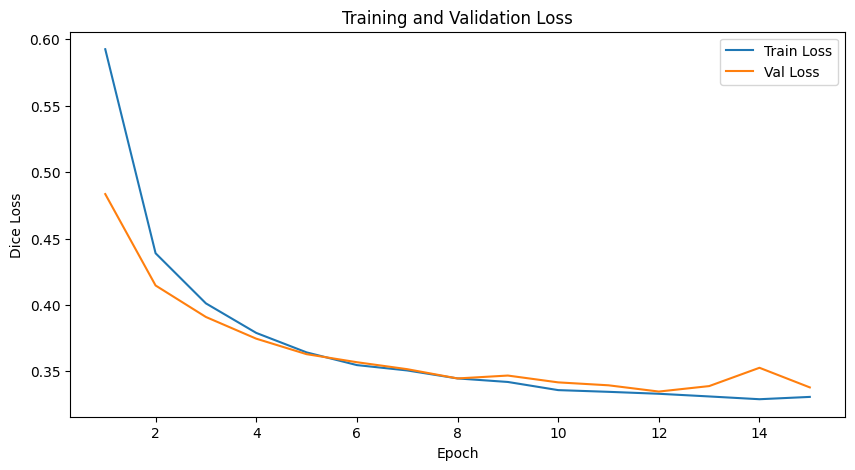

In [62]:
# plot results of training
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mean_train_losses)+1), mean_train_losses, label='Train Loss')
plt.plot(range(1, len(mean_val_losses)+1), mean_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 5 Evaluate on the validation set

#### 5.1 Load the trained model

In [63]:
# load SAM model configuration
model_config = SamConfig.from_pretrained('wanglab/medsam-vit-base')
processor = SamProcessor.from_pretrained('wanglab/medsam-vit-base')

# create instance of the model architecture with the loaded configuration
sam_model = SamModel(config=model_config)
# load fine-tuned weights
sam_model.load_state_dict(torch.load(os.path.join(model_path, f'{model_name}.pth')))

<All keys matched successfully>

In [64]:
# set the device to cuda if available, otherwise use cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

#### 5.2 Visual inspection of predicted masks

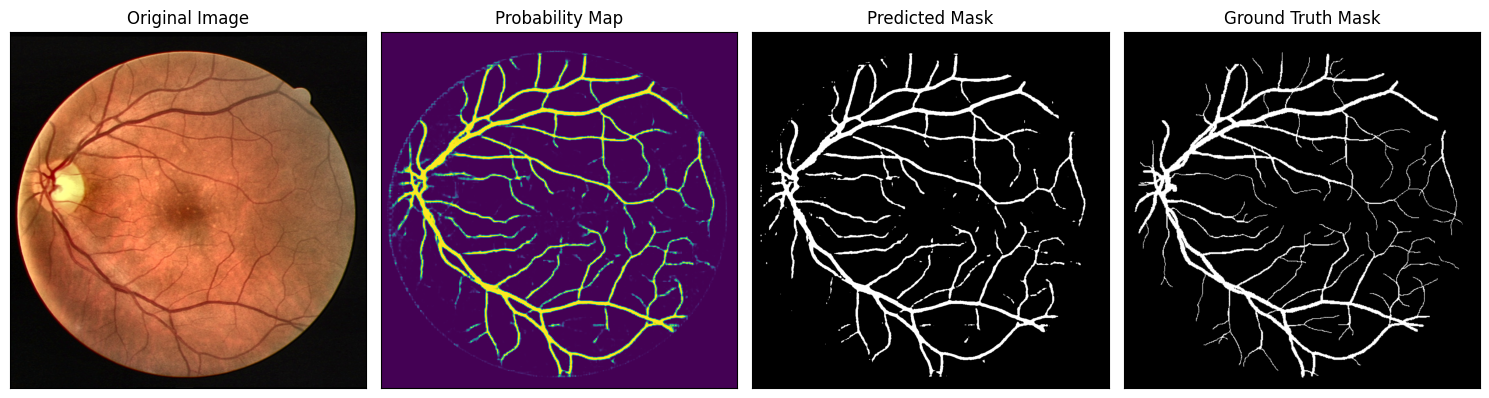

In [65]:
# load validation images and masks
# get file names of validation images
images_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'images', '*.jpg'))
images_files_val.sort()

# get file names of validation masks
masks_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'masks', '*.jpg'))
masks_files_val.sort()

# select random image number
image_number = 1

# load image and mask
image = np.array(Image.open(images_files_val[image_number]).convert('RGB'))
y_true = np.array(Image.open(masks_files_val[image_number]).convert('1'))

# define input points
input_points = generate_input_points()

# use input points as prompts for better result
inputs = processor(image, input_points=input_points, return_tensors="pt")

# input tensor to GPU if available
inputs = {k: v.to(device) for k, v in inputs.items()}
# set SAM model to evaluation mode
sam_model.eval()


# forward pass
with torch.no_grad():
  outputs = sam_model(**inputs, multimask_output=False)
  # reshape as masks outputs are 256x256
  outputs = nn.functional.interpolate(outputs.pred_masks.squeeze(1),
                                      size=(1024, 1024),
                                      mode='bilinear',
                                      align_corners=False)

# apply sigmoid
y_prob = torch.sigmoid(outputs)
# convert soft mask to hard mask
y_prob = y_prob.cpu().numpy().squeeze()
# convert to binary using threshold
y_pred = (y_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title('Original Image')

# Plot the second image on the right
axes[1].imshow(y_prob)  # Assuming the second image is grayscale
axes[1].set_title('Probability Map')

# Plot the second image on the right
axes[2].imshow(y_pred, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title('Predicted Mask')

# Plot the second image on the right
axes[3].imshow(y_true, cmap='gray')  # Assuming the second image is grayscale
axes[3].set_title('Ground Truth Mask')

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# adjust spacing between subplots
plt.tight_layout()

# Display the images side by side
plt.show()

#### 5.3 Evaluate with metrics

In [66]:
# empty dictionaries to store metrics
all_metrics = {}

# define thresholds to optimize
thresholds = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]

# load validation images and masks
# get file names of validation images
images_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'images', '*.jpg'))
images_files_val.sort()

# get file names of validation masks
masks_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'masks', '*.jpg'))
masks_files_val.sort()

# set model to evaluation mode
sam_model.eval()

# for tqdm progress bar
total_items = len(images_files_val)

for image_path, mask_path in tqdm(zip(images_files_val, masks_files_val), total=total_items):
    # load image and mask
    image = np.array(Image.open(image_path).convert('RGB'))
    y_true = np.array(Image.open(mask_path).convert('1'))

    # define input points
    input_points = generate_input_points()

    # use input points as prompts for better result
    inputs = processor(image, input_points=input_points, return_tensors="pt")

    # input tensor to GPU if available
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # forward pass
    with torch.no_grad():
      outputs = sam_model(**inputs, multimask_output=False)
      # reshape as masks outputs are 256x256
      outputs = nn.functional.interpolate(outputs.pred_masks.squeeze(1),
                                          size=(1024, 1024),
                                          mode='bilinear',
                                          align_corners=False)

    # apply sigmoid
    y_prob = torch.sigmoid(outputs)
    # convert soft mask to hard mask
    y_prob = y_prob.cpu().numpy().squeeze()
    # calculate metrics for defined thresholds
    metrics = calculate_metrics(y_true, y_prob, thresholds)

    # aggregate metrics for all images
    for threshold, metric_values in metrics.items():
        if threshold not in all_metrics:
            all_metrics[threshold] = []
        all_metrics[threshold].append(metric_values)

# print mean metrics
for threshold, metric_values in all_metrics.items():
    print(f'\nResults for {threshold}:')
    for metric_name in metric_values[0].keys():
        mean_metric = np.mean([metric[metric_name] for metric in metric_values])
        print(f'Mean {metric_name.capitalize()}: {round(mean_metric, 4)}')

100%|██████████| 78/78 [09:45<00:00,  7.51s/it]


Results for threshold_0.35:
Mean Accuracy: 0.964
Mean Precision: 0.7451
Mean Recall: 0.8052
Mean Dice: 0.7721
Mean Iou: 0.6325

Results for threshold_0.4:
Mean Accuracy: 0.9651
Mean Precision: 0.7607
Mean Recall: 0.7945
Mean Dice: 0.7755
Mean Iou: 0.6369

Results for threshold_0.45:
Mean Accuracy: 0.9661
Mean Precision: 0.7755
Mean Recall: 0.7838
Mean Dice: 0.7778
Mean Iou: 0.64

Results for threshold_0.5:
Mean Accuracy: 0.9669
Mean Precision: 0.7895
Mean Recall: 0.7728
Mean Dice: 0.7792
Mean Iou: 0.6418

Results for threshold_0.55:
Mean Accuracy: 0.9675
Mean Precision: 0.8031
Mean Recall: 0.7613
Mean Dice: 0.7798
Mean Iou: 0.6426

Results for threshold_0.6:
Mean Accuracy: 0.968
Mean Precision: 0.8165
Mean Recall: 0.7491
Mean Dice: 0.7796
Mean Iou: 0.6422

Results for threshold_0.65:
Mean Accuracy: 0.9683
Mean Precision: 0.8303
Mean Recall: 0.7357
Mean Dice: 0.7783
Mean Iou: 0.6405
